In [1]:
import numpy as np
import matplotlib.pyplot as plt

import chainer.optimizers as Opt
import chainer.functions as F
import chainer.links as L
import chainer.datasets as ds
import chainer.dataset.convert as con
from chainer.iterators import SerialIterator as siter
from chainer import optimizer_hooks as oph
from chainer import Variable,Chain,config,cuda

from tqdm import tqdm
from IPython import display
import princess as ohm

In [2]:
all_list = []
ohm.add_labeled_data("princess_fig",0,all_list)

[('princess_fig/kisaki15.jpg', 0),
 ('princess_fig/kisaki01.jpg', 0),
 ('princess_fig/kisaki14.jpg', 0),
 ('princess_fig/kisaki18.jpg', 0),
 ('princess_fig/kisaki08.jpg', 0),
 ('princess_fig/kisaki00.jpg', 0),
 ('princess_fig/kisaki15b.jpg', 0),
 ('princess_fig/kisaki02.jpg', 0),
 ('princess_fig/kisaki12.jpg', 0),
 ('princess_fig/kisaki13.jpg', 0),
 ('princess_fig/kisaki04.jpg', 0),
 ('princess_fig/kisaki09.jpg', 0),
 ('princess_fig/kisaki10b.jpg', 0),
 ('princess_fig/kisaki07.jpg', 0),
 ('princess_fig/kisaki16.jpg', 0),
 ('princess_fig/kisaki06.jpg', 0),
 ('princess_fig/kisaki03.jpg', 0),
 ('princess_fig/kisaki10.jpg', 0),
 ('princess_fig/kisaki05.jpg', 0),
 ('princess_fig/kisaki17.jpg', 0),
 ('princess_fig/kisaki11.jpg', 0)]

In [3]:
dataset = ds.LabeledImageDataset(all_list)

In [4]:
train = ds.TransformDataset(dataset, ohm.labeled64)

In [5]:
xtrain,_ = con.concat_examples(train)

In [6]:
Dtrain,ch,Ny,Nx = xtrain.shape
print(Dtrain,ch,Ny,Nx)

21 3 64 64


In [7]:
class Generator(Chain):
    def __init__(self,zsize, Nx = Nx, Ny = Ny, H1=256*ch, H2=64*ch, H3=16*ch, H4=4*ch):
        layers = {}
        layers['l1'] = L.Linear(zsize, Ny//16 * Nx//16 * H1)
        layers['bnorm1'] = L.BatchNormalization(H1)
        layers['dcnn1'] = ohm.CBR(H1, H2,"up")
        layers['dcnn2'] = ohm.CBR(H2, H3,"up")
        layers['dcnn3'] = ohm.CBR(H3, H4,"up")
        layers['dcnn4'] = ohm.CBR(H4, ch,"up")
        super().__init__(**layers)
    def __call__(self,x):
        h = self.l1(x)
        h = F.dropout(h)
        h = F.relu(h)
        h = h.reshape(len(h),256*ch,4,4)
        h = self.bnorm1(h)
        h = self.dcnn1(h)
        h = self.dcnn2(h)
        h = self.dcnn3(h)
        h = self.dcnn4(h)
        y = F.clip(h,0.0,1.0)
        return y

In [8]:
class Discriminator(Chain):
    def __init__(self, C, ch = ch,H1=64,H2=128,H3=256,H4=512):
        layers = {}
        layers['cnn1'] = ohm.CBR(ch,H1,"down",bn=False,activation=F.leaky_relu, dropout=False)
        layers['cnn2'] = ohm.CBR(H1,H2,"down",bn=False,activation=F.leaky_relu, dropout=False)
        layers['cnn3'] = ohm.CBR(H2,H3,"down",bn=False,activation=F.leaky_relu, dropout=False)
        layers['cnn4'] = ohm.CBR(H3,H4,"down",bn=False,activation=F.leaky_relu, dropout=False)
        layers['l1'] = L.Linear(None,C)
        super().__init__(**layers)
    def __call__(self,x):
        h = self.cnn1(x)
        h = self.cnn2(h)
        h = self.cnn3(h)
        h = self.cnn4(h)
        h = self.l1(h)
        y = F.dropout(h)
        return y

In [9]:
zsize = 2
C = 1
gen = Generator(zsize)
dis = Discriminator(C)

In [10]:
optgen = Opt.Adam(alpha=0.0005, beta1=0.5)
optgen.setup(gen)
#optgen.add_hook(oph.WeightDecay(0.000001))
optgen.add_hook(oph.GradientClipping(0.1))
#genを早めにしてNNを軽めにしてもあり）やると見た目が綺麗。青線が下に下がる

optdis = Opt.Adam(alpha=0.0001, beta1=0.5)
optdis.setup(dis)

#0.0001だと強すぎてグレーに
#optdis.add_hook(oph.WeightDecay(0.000001))
optdis.add_hook(oph.GradientClipping(0.1))

cuda.get_device(3).use()
gen.to_gpu()
dis.to_gpu()

In [11]:
train_gen_loss = []
train_dis_loss1 = []
train_dis_loss2 = []
result = [train_gen_loss,train_dis_loss1,train_dis_loss2]

 10%|▉         | 99/1000 [00:44<06:00,  2.50it/s]

epoch 100


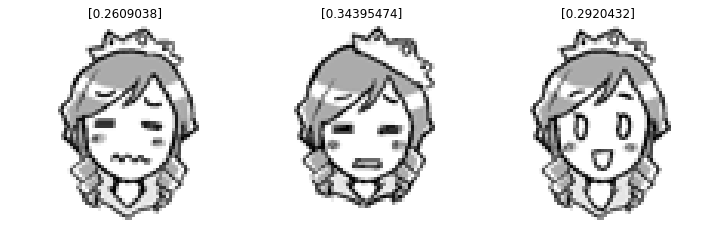

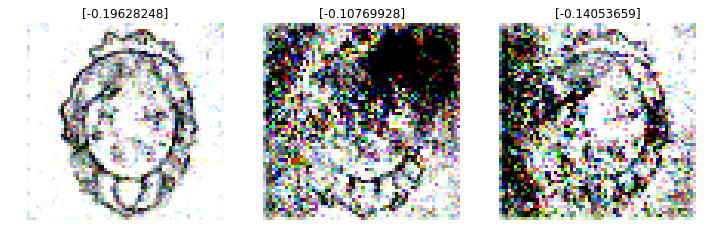

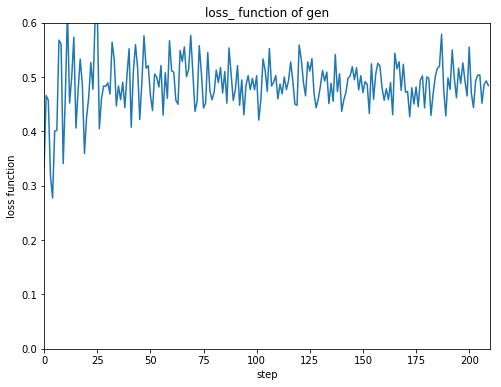

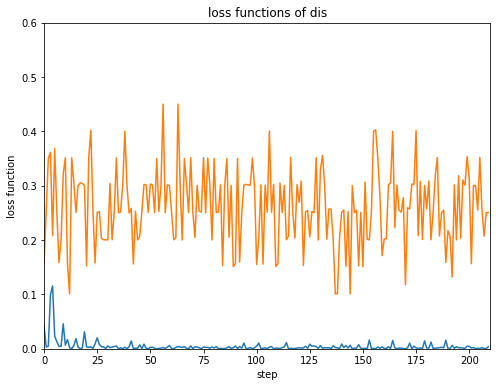

 20%|█▉        | 199/1000 [01:26<05:11,  2.57it/s]

epoch 200


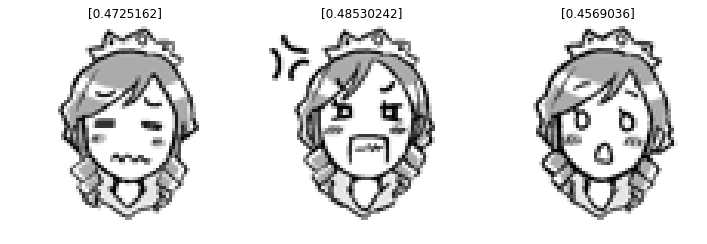

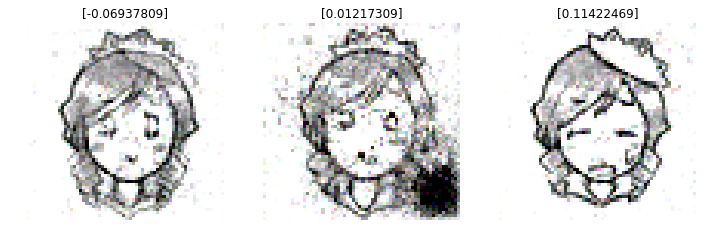

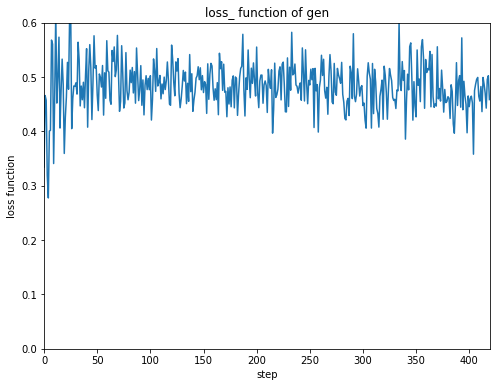

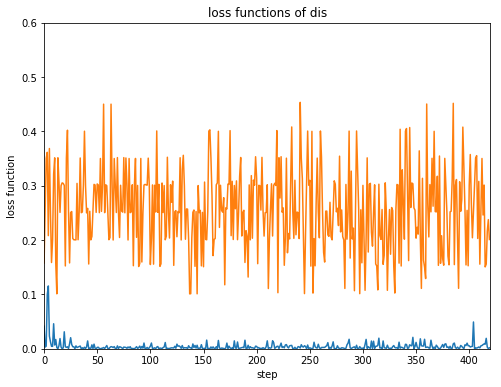

 30%|██▉       | 299/1000 [02:10<05:05,  2.29it/s]

epoch 300


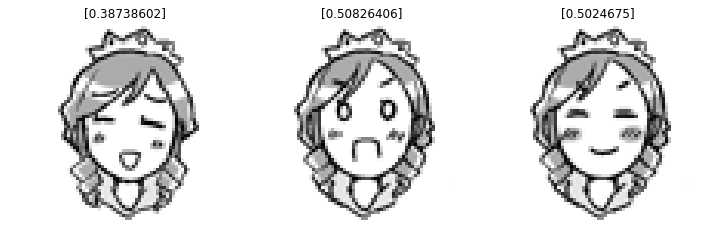

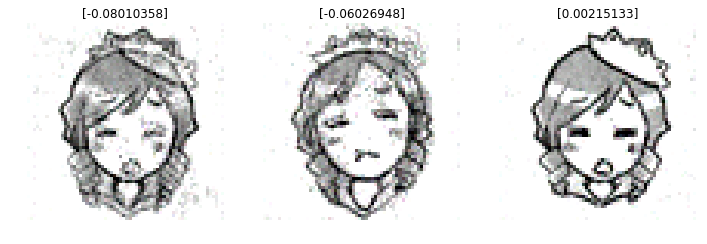

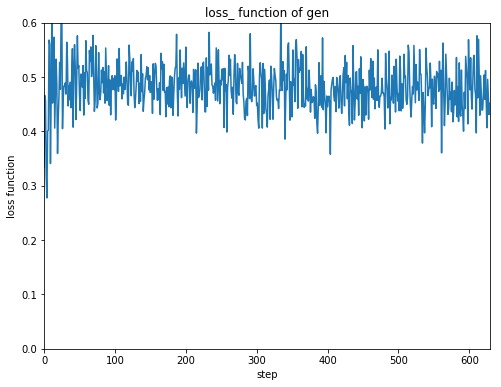

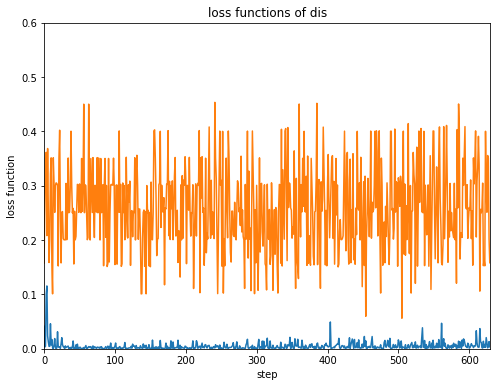

 40%|███▉      | 399/1000 [02:53<03:56,  2.54it/s]

epoch 400


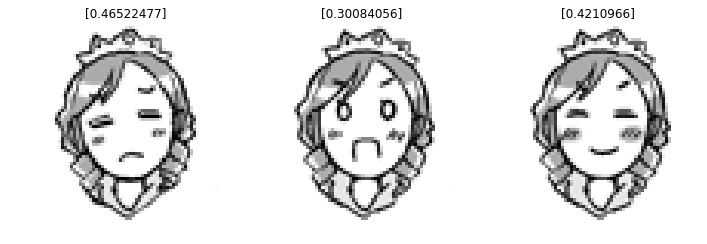

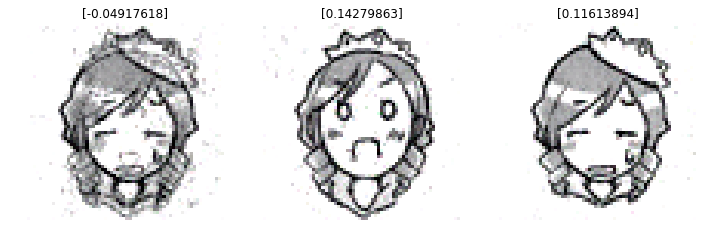

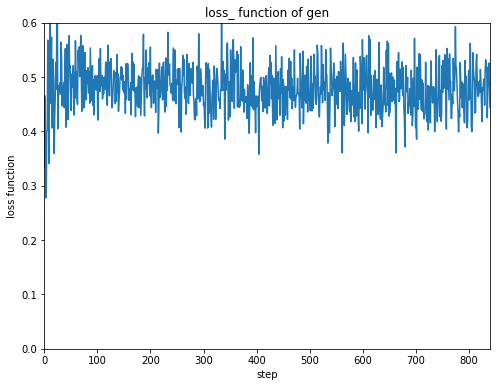

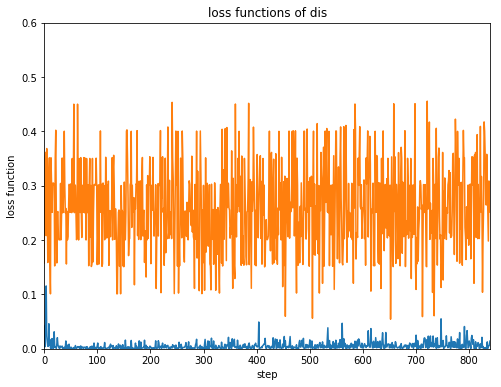

 50%|████▉     | 499/1000 [03:39<03:23,  2.46it/s]

epoch 500


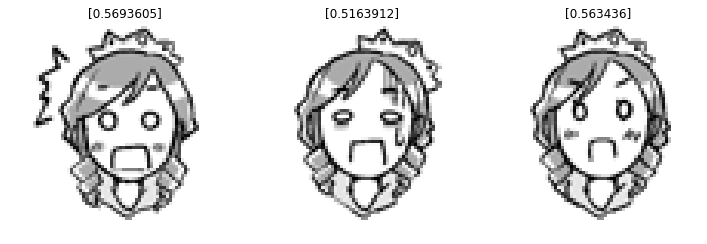

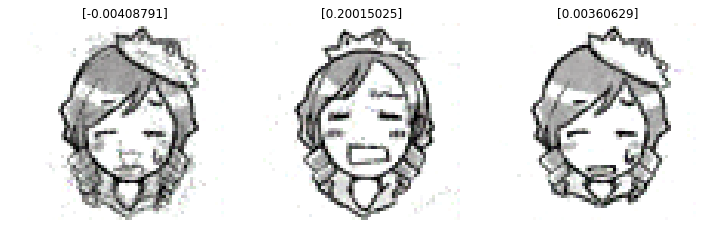

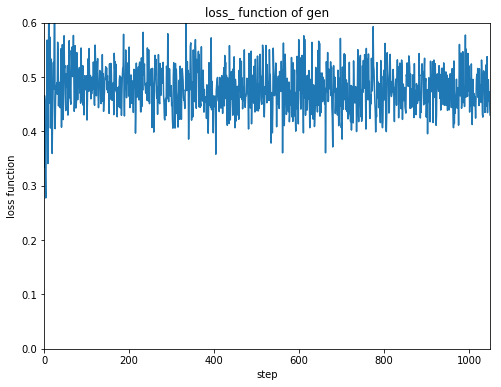

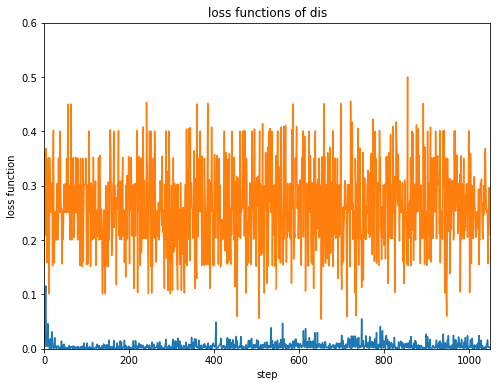

 60%|█████▉    | 599/1000 [04:22<02:45,  2.42it/s]

epoch 600


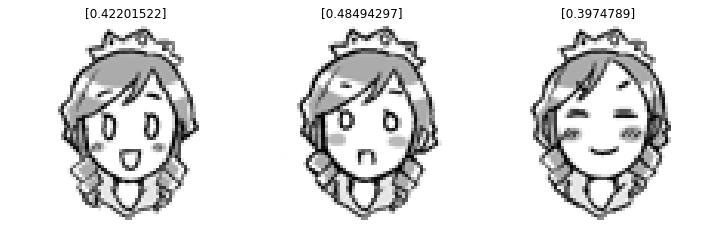

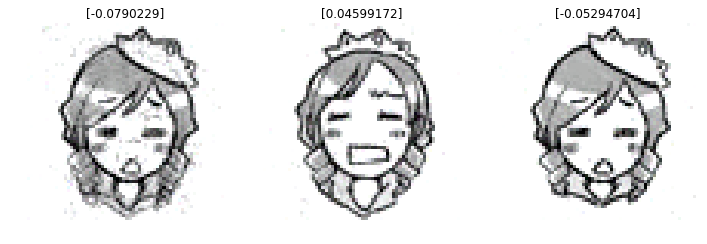

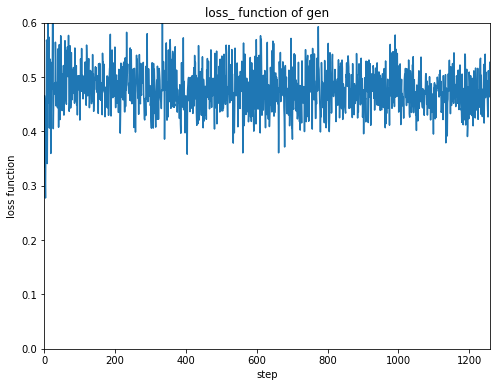

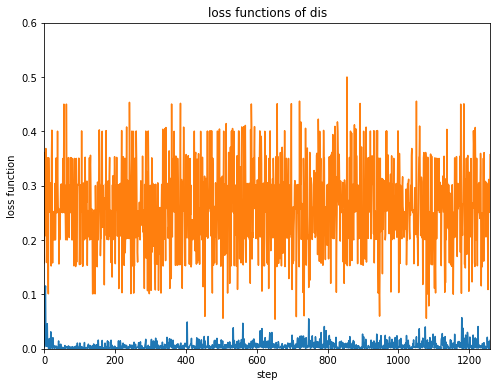

 70%|██████▉   | 699/1000 [05:07<02:05,  2.39it/s]

epoch 700


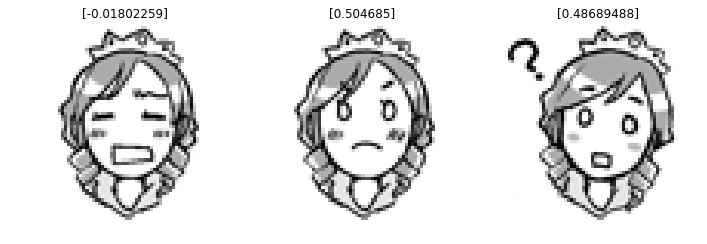

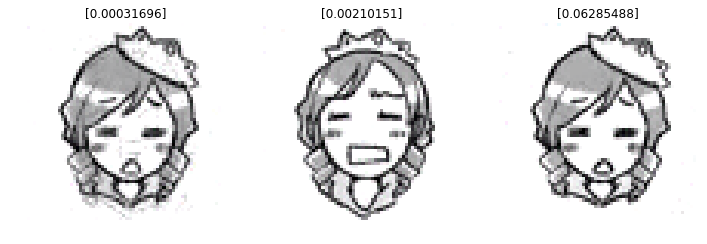

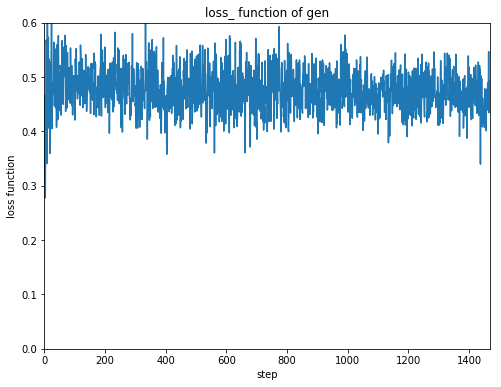

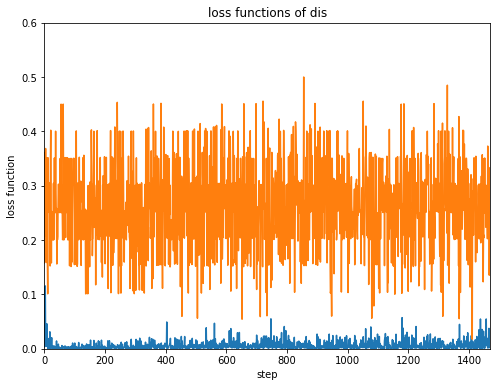

 80%|███████▉  | 799/1000 [05:49<01:18,  2.56it/s]

epoch 800


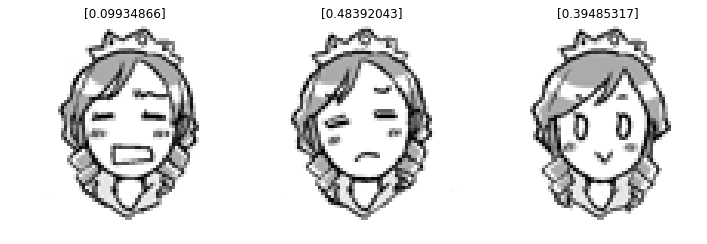

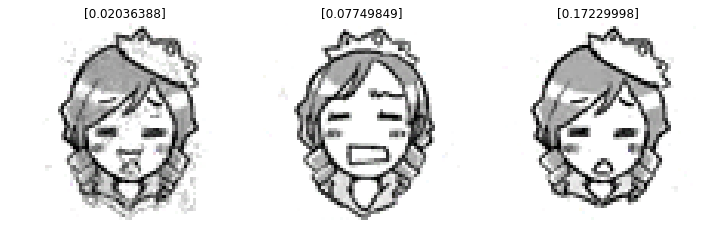

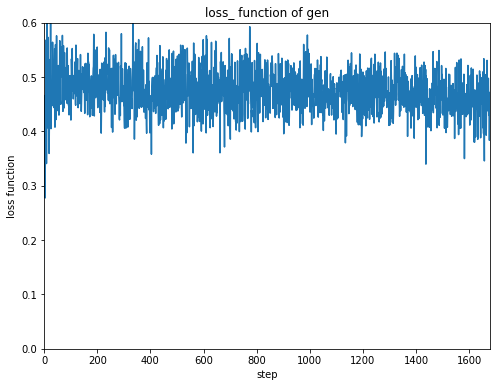

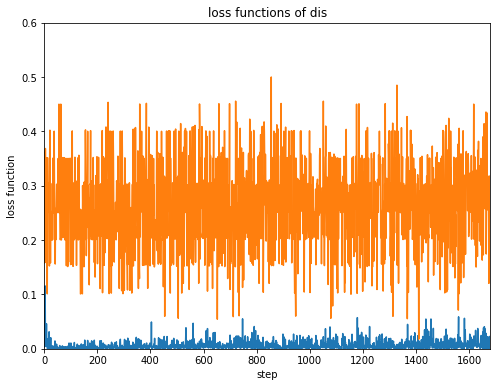

 90%|████████▉ | 899/1000 [06:32<00:40,  2.49it/s]

epoch 900


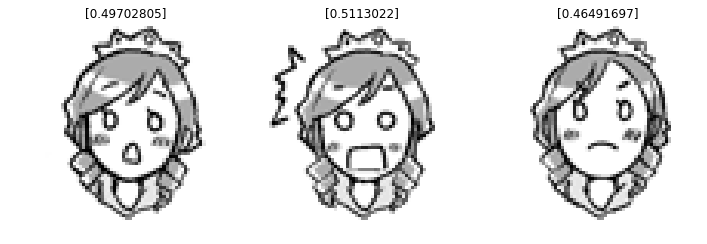

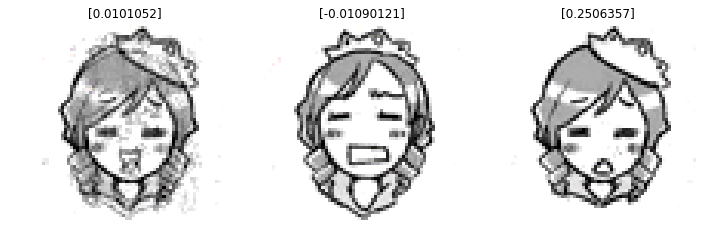

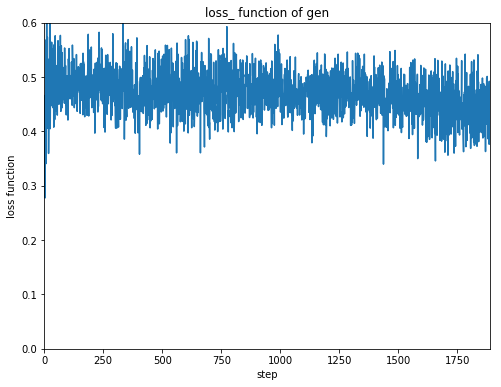

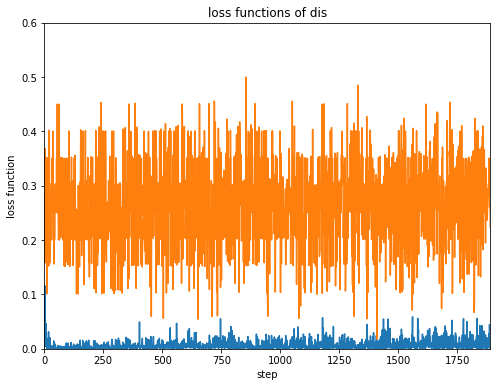

100%|█████████▉| 999/1000 [07:16<00:00,  2.34it/s]

epoch 1000


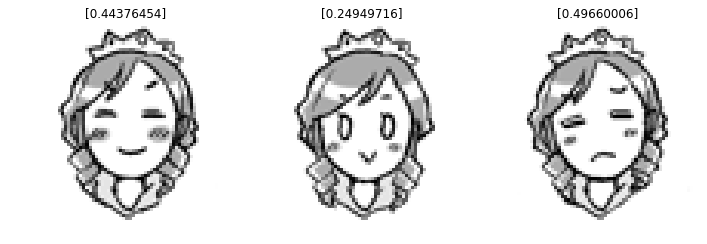

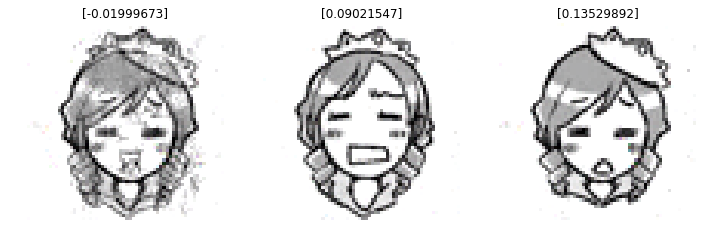

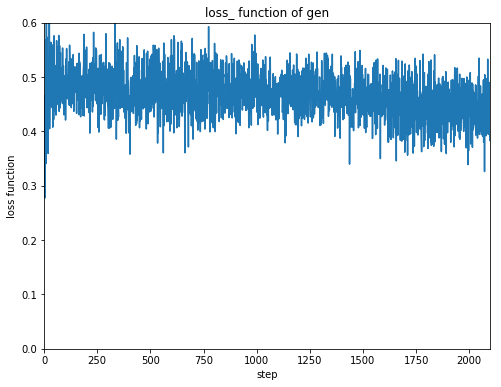

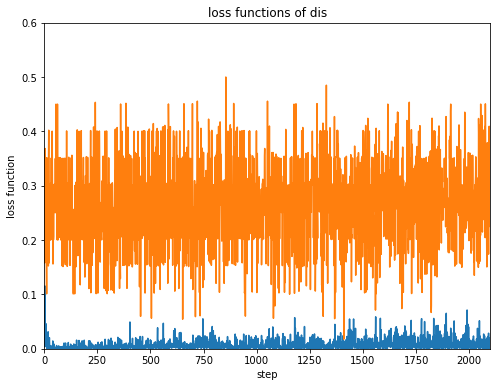

In [12]:
foldername = 'output_GAN'
nepoch = 1000
batch_size = 10
Nfig = 3
ztest = cuda.to_gpu(np.random.randn(Nfig*zsize).reshape(Nfig,zsize).astype(np.float32))
            
train_iter = siter(train, batch_size)
with tqdm(total = nepoch) as pbar:
    while train_iter.epoch < nepoch:
            pbar.update(train_iter.is_new_epoch)
            batch = train_iter.next()
            xtrain,ttrain = con.concat_examples(batch)
            ztrain = np.random.randn(len(xtrain)*zsize).reshape(len(xtrain),zsize).astype(np.float32)
            data = cuda.to_gpu([xtrain,ztrain])
            ohm.learning_process_GAN(gen,dis,optgen,optdis,data,result,T= 5)          
            if train_iter.is_new_epoch == 1 and train_iter.epoch%100 == 0:
                #display.clear_output(wait=True)
                ohm.temp_image_lsgan(train_iter.epoch,foldername+'/test',data[0],ztest,gen,dis)
                ohm.plot_result(result[0],'loss_ function of gen','step','loss function',0.0,0.6)            
                ohm.plot_result2(result[1],result[2],'loss functions of dis','step','loss function',0.0,0.6)            